Examination for the "Inverse problems and machine learning" module 
============
**Luca Bartolomei - luca.bartolomei5@unibo.it - EIT4SEMM PhD student**

The examination consists of the following steps.

1. Make sure you have access to a computer with a CUDA capable GPU. On that computer, follow instructions in "Installation.txt" to set-up your environment and install PyTorch, ODL, ASTRA Toolbox and SciKit-image. Note that instructions are written for Linux, but you should be able to use Windows as well. 

2. Work through the examples in the iPython notebook "learned_reconstruction_pytorch.ipynb". This notebook includes the following:
(a) Simulate 2D parallel-beam tomographic data from 28 x 28 pixel images representing MNIST handwritten digits. 
Note: The reason for choosing such small 2D images is to ensure the training (for the learned methods, see (c) below) is doable on modest computing hardware within reasonable time.
(b) Set-up and perform reconstruction using two model based methods: Filtered back-projection (FBP) and total variation
(c) Set-up and perform reconstruction using two learned methods, both trained against suitable supervised data with the square 2-norm as loss. The two learned methods are: (i) learned post-processing of FBP (=convolutional neural network trained to denoise/restore a FBP reconstruction) and (ii) learned gradient descent (=unrolled gradient descent), which is described in slides 23-24 (=pages 83-85) for lecture2.

3. Implement learned primal-dual (without memory), see description in slides 25-26 (=pages 86, 88-91) for lecture2. The solution (training + test) should be contained in a iPython notebook that can be executed in an environment that is set-up as in (1) above. Make sure you train and test on same data as unrolled gradient descent in 2(c)(ii) above, see the iPython notebook "learned_reconstruction_pytorch.ipynb" for that. Share you solution by providing me with a link to a suitable repository (like GitHub) for the iPython notebook that contains the learned primal-dual implementation.

## Step 1: Installation.txt
- I build a conda environment with Python and all packages needed: I didn't use any additional package in the solution notebook, so compatibility wouldn't be problem.
  - I build from source ODL as requested.

**Select the conda kernel before import libraries**

In [1]:
%matplotlib inline
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import odl
from odl.contrib.torch import OperatorModule
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch import optim
import torchvision
from torchvision import datasets, transforms
torch.manual_seed(123);  # reproducibility

## Step 2: learned_reconstruction_pytorch.ipynb
- I run step by step example and try to understand all phases.
  - Also I saved checkpoints so we can compare techniques from learned_reconstruction_pytorch.ipynb without train each time.
  - I copy/paste useful code here and add comments.

In [2]:
# Load training and test data (from the official MNIST example,
# https://github.com/pytorch/examples/blob/master/mnist/main.py)
trafo = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
dset_train = datasets.MNIST('./data', train=True, download=True, transform=trafo)
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=50, shuffle=True)

dset_test = datasets.MNIST('./data', train=False, transform=trafo)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=50, shuffle=True)

In [3]:
#ODL Ray transform + Filtered BackProjection
num_angles = 5

space = odl.uniform_discr([-14, -14], [14, 14], [28, 28], dtype='float32')
geometry = odl.tomo.parallel_beam_geometry(space, num_angles=num_angles)

#See simulated ray detector array size and print number of angles
# 41 > 28: need more rays to cover all image (41~sqrt(28^2+28^2))
print(f"Detector size: {geometry.detector.size}")
print(f"Num angles: {num_angles}")

fwd_op = odl.tomo.RayTransform(space, geometry)
fbp_op = odl.tomo.fbp_op(fwd_op)
#Pytorch porting of ODL
fwd_op_mod = OperatorModule(fwd_op)
fwd_op_adj_mod = OperatorModule(fwd_op.adjoint)
fbp_op_mod = OperatorModule(fbp_op)

Detector size: 41
Num angles: 5


In [4]:
def generate_data(images):
    """Create noisy projection data from images.
    
    The data is generated according to ::
        
        data = fwd_op(images) + noise
        
    where ``noise`` is standard white noise.
    
    Parameters
    ----------
    images : `Variable`, shape ``(B, C, 28, 28)``
        Input images for the data generation.
        
    Returns
    -------
    data : `Variable`, shape ``(B, C, 5, 41)``
        Projection data stack.
    """
    torch.manual_seed(123)#Same noise for all data?
    data = fwd_op_mod(images)
    data += Variable(torch.randn(data.shape)).type_as(data)
    return data


def show_image_matrix(image_batches, titles=None, indices=None, **kwargs):
    """Visualize a 2D set of images arranged in a grid.

    This function shows a 2D grid of images, where the i-th column
    shows images from the i-th batch. The typical use case is to compare
    results of different approaches with the same data, or to compare
    against a ground truth.

    Parameters
    ----------
    image_batches : sequence of `Tensor` or `Variable`
        List containing batches of images that should be displayed.
        Each tensor should have the same shape after squeezing, except
        for the batch axis.
    titles : sequence of str, optional
        Titles for the colums in the plot. By default, titles are empty.
    indices : sequence of int, optional
        Object to select the subset of the images that should be shown.
        The subsets are determined by slicing along the batch axis, i.e.,
        as ``displayed = image_batch[indices]``. The default is to show
        everything.
    kwargs :
        Further keyword arguments that are passed on to the Matplotlib
        ``imshow`` function.
    """

    if indices is None:
        displayed_batches = image_batches
    else:
        displayed_batches = [batch[indices] for batch in image_batches]

    displayed_batches = [batch.data if isinstance(batch, Variable) else batch
                         for batch in displayed_batches]

    nrows = len(displayed_batches[0])
    ncols = len(displayed_batches)

    if titles is None:
        titles = [''] * ncols

    figsize = 2
    fig, rows = plt.subplots(
        nrows, ncols, sharex=True, sharey=True,
        figsize=(ncols * figsize, figsize * nrows))

    if nrows == 1:
        rows = [rows]

    for i, row in enumerate(rows):
        if ncols == 1:
            row = [row]
        for name, batch, ax in zip(titles, displayed_batches, row):
            if i == 0:
                ax.set_title(name)
            ax.imshow(batch[i].squeeze(), **kwargs)
            ax.set_axis_off()
    plt.show()

In [5]:
# Get a batch of test images and generate test projection data
for i, (images, _) in enumerate(test_loader):
    if i == 1:
        break

test_images = Variable(images)
test_data = generate_data(test_images)

In [6]:
#Filtered backprojection test
fbp_recos = fbp_op_mod(test_data)
print('Average error:', F.mse_loss(fbp_recos, test_images).item() / len(test_images))

Average error: 0.017931634187698366


In [7]:
class FullRecoNet(nn.Module):
    def __init__(self):
        super(FullRecoNet, self).__init__()
        #Note: input is constrained to a detector of 41 rays and 5 angles...
        #CNN networks don't have this side-effect
        self.lin1 = nn.Linear(5 * 41, 1024)
        self.lin2 = nn.Linear(1024, 1024)
        self.lin3 = nn.Linear(1024, 28 ** 2)

    def forward(self, x):
        #Input must be flatten
        x = F.relu(self.lin1(x.view(-1, 5 * 41)))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        #Output reshape
        return x.view(-1, 1, 28, 28)

In [8]:
use_cuda = True
loss_test = nn.MSELoss()
full_net = FullRecoNet()
if use_cuda:
    full_net = full_net.cuda()
    test_data = test_data.cuda()
    test_images = test_images.cuda()

#Model loading: trained in step 2
state_dict = torch.load("weights/full_net.tar")
full_net.load_state_dict(state_dict)

def test():
    full_net.eval()
    loss = loss_test(full_net(test_data), test_images) / len(test_images)
    print('\nTest set: Average loss: {:.6f}'.format(loss.item()))

test()
print('Total number of parameters:',
      sum(param.numel() for param in full_net.parameters()))


Test set: Average loss: 0.002374
Total number of parameters: 2064144


In [9]:
class DenoisingNet(nn.Module):
    def __init__(self):
        super(DenoisingNet, self).__init__()
        #CNN only constrain channel axis
        #[B 1 H W]
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [10]:
use_cuda = True
loss_test = nn.MSELoss()
denoise_net = DenoisingNet()
if use_cuda:
    denoise_net = denoise_net.cuda()
    test_data = test_data.cuda()
    test_images = test_images.cuda()

#Model loading: trained in step 2
state_dict = torch.load("weights/denoise_net.tar")
denoise_net.load_state_dict(state_dict)

def test():
    denoise_net.eval()
    loss = (loss_test(denoise_net(fbp_op_mod(test_data)), test_images) /
            len(test_images))
    print('\nTest set: Average loss: {:.6f}'.format(loss.item()))

test()
print('Total number of parameters:',
      sum(param.numel() for param in denoise_net.parameters()))


Test set: Average loss: 0.002758
Total number of parameters: 9857


In [11]:
class IterativeNet(nn.Module):
    def __init__(self, niter, op, op_adj, init_op=None):
        super(IterativeNet, self).__init__()
        self.niter = niter
        self.op = op
        self.op_adj = op_adj
        self.init_op = init_op

        # Make iterative blocks
        for it in range(niter):
            block = []
            block.append(nn.Conv2d(2, 32, 3, padding=1))
            block.append(nn.Conv2d(32, 32, 3, padding=1))
            block.append(nn.Conv2d(32, 1, 3, padding=1))
            mod_block = nn.ModuleList(block)
            setattr(self, 'mod_block_iter_{}'.format(it), mod_block)

    def forward(self, y):
        if self.init_op is None:
            # Effectively start from zero (not counting to iterations)
            cur = self.op_adj(y)
        else:
            cur = self.init_op(y)

        for it in range(self.niter):

            # Get block of modules for dx
            mod_block = getattr(self, 'mod_block_iter_{}'.format(it))

            # Set gradient of ||A(x) - y||^2
            grad = self.op_adj(self.op(cur) - y)

            # Combine the two with learable parameters
            dx = torch.cat([cur, grad], dim=1)
            for i, mod in enumerate(mod_block):
                dx = mod(dx)
                if i < len(mod_block) - 1:
                    dx = F.relu(dx)

            # Iteration update
            cur = cur + dx

        return cur

In [12]:
use_cuda = True
loss_test = nn.MSELoss()
iter_net = IterativeNet(niter=2, op=fwd_op_mod, op_adj=fwd_op_adj_mod,
                        init_op=fbp_op_mod)
if use_cuda:
    iter_net = iter_net.cuda()
    test_data = test_data.cuda()
    test_images = test_images.cuda()

#Model loading
state_dict = torch.load("weights/iter_net.tar")
iter_net.load_state_dict(state_dict)

def test():
    iter_net.eval()
    loss = loss_test(iter_net(test_data), test_images) / len(test_images)
    print('\nTest set: Average loss: {:.6f}'.format(loss.item()))

test()
print('Total number of parameters:',
      sum(param.numel() for param in iter_net.parameters()))


Test set: Average loss: 0.002799
Total number of parameters: 20290


## Step 3: Learned Primal Dual Hybrid Gradient (Unrolled)

**Algorithm**

1. Initialize: $x_0 \in X, y_0 \in Y$
2. **for** $i=1,2,3,\dots,N$ **do**
3. &nbsp;&nbsp; $y_{i+1} \leftarrow \Gamma_{\theta^d_{i+1}}(y_i, \mathcal{A}(x_i),y)$
4. &nbsp;&nbsp; $x_{i+1} \leftarrow \Lambda_{\theta^p_{i+1}}(x_i, \partial[\mathcal{A}(x_i)]^*(y_{i+1}))$
5. $\mathcal{R}_\Theta(y) \leftarrow x_N$ with $\Theta = (\theta^d_1,\dots,\theta^p_N)$

From lecture2.pdf there is a visual rappresentation.

Primal (X) and dual (Y) domains are respectively original MNIST image and sinogram.

![pd_learned](imgs/pd_learned.png)

This kind of architecture is a family of **Residual Networks (ResNet)**, where neural layers learn the residual to add to previous state.

Also ResNet can be seen as a particular case of **Recurrent Neural Networks (RNN)** if all layers share same weights ($\theta^d_1=\dots=\theta^d_N, \theta^p_1=\dots=\theta^p_N$)

The key idea behind is update a initial state until $N$ iterations.

Step 3 require a no memory version of PDHG, so if I understood well the intermediate state is somehow cut off: the architecture is more similar to a traditional **Feed Forward Network**.

**Algorithm (no memory)**

1. Initialize: $x_0 \in X, y_0 \in Y$
2. **for** $i=1,2,3,\dots,N$ **do**
3. &nbsp;&nbsp; $y_{i+1} \leftarrow \Gamma_{\theta^d_{i+1}}(\mathcal{A}(x_i),y)$
4. &nbsp;&nbsp; $x_{i+1} \leftarrow \Lambda_{\theta^p_{i+1}}(\partial[\mathcal{A}(x_i)]^*(y_{i+1}))$
5. $\mathcal{R}_\Theta(y) \leftarrow x_N$ with $\Theta = (\theta^d_1,\dots,\theta^p_N)$

![pd_learned](imgs/pd_learned_nomemory.png)

As done as before in IterativeNet, we use the FBP reconstruction as start of the iterative loop.

In [13]:
#Code based from IterativeNet
class PDIterativeNet(nn.Module):
    def __init__(self, niter, op, op_adj, init_op=None, use_memory = False):
        super(PDIterativeNet, self).__init__()
        self.niter = niter
        self.op = op
        self.op_adj = op_adj
        self.use_memory = use_memory
        self.init_op = init_op

        # Make iterative blocks
        for key in ['x','y']:
            for it in range(niter):
                block = []
                #Different channels size for primal and dual layers
                in_channels = 2 if key == 'x' else 3
                
                #ReLU is injected here
                block.append(nn.Conv2d(in_channels, 32, 3, padding=1))
                block.append(nn.ReLU())
                block.append(nn.Conv2d(32, 32, 3, padding=1))
                block.append(nn.ReLU())
                block.append(nn.Conv2d(32, 1, 3, padding=1))
                mod_block = nn.ModuleList(block)
                setattr(self, f'mod_block_iter_{key}_{it}', mod_block)

    def usememory(self,use_memory):
        """
        Enable or disable usage of current state (cur_x, cur_y) in forward step.
        If disable then input is concatenated with zeros.
        """
        self.use_memory = use_memory

    def forward(self, y):
        if self.init_op is None:
            # Effectively start from zero (not counting to iterations)
            cur_x = self.op_adj(y)
        else:
            cur_x = self.init_op(y)

        #Return all intermediate states for visualization
        all_results_x = [cur_x]
        
        cur_y = y

        for it in range(self.niter):

            # Get block of modules for dx,dy
            mod_block_x = getattr(self, 'mod_block_iter_x_{}'.format(it))
            mod_block_y = getattr(self, 'mod_block_iter_y_{}'.format(it))

            #Zero cur_y if use_memory is false
            y_input_list = [cur_y,self.op(cur_x),y] if self.use_memory else [torch.zeros_like(cur_y),self.op(cur_x),y]
            dy = torch.cat(y_input_list,dim=1)
            for mod in mod_block_y:
                dy = mod(dy)

            # Dual update
            cur_y = cur_y + dy

            #Zero cur_x if use_memory is false
            x_input_list = [cur_x, self.op_adj(cur_y)] if self.use_memory else [torch.zeros_like(cur_x), self.op_adj(cur_y)]
            dx = torch.cat(x_input_list, dim=1)
            for mod in mod_block_x:
                dx = mod(dx)

            # Primal update
            cur_x = cur_x + dx

            #Save intermediate
            all_results_x.append(cur_x)
            

        return all_results_x

- Let's train the network with option ```use_memory=False``` and see some results.
  - ```pd_iter_net(...)[-1]``` means that we drop intermediate results.

In [14]:
use_cuda = True
learning_rate = 1e-3
log_interval = 20
epochs = 1
pd_iter_net = PDIterativeNet(niter=2, op=fwd_op_mod, op_adj=fwd_op_adj_mod,
                        init_op=fbp_op_mod, use_memory=False)
loss_train = nn.MSELoss()
loss_test = nn.MSELoss()

if use_cuda:
    pd_iter_net = pd_iter_net.cuda()
    test_data = test_data.cuda()
    test_images = test_images.cuda()

optimizer = optim.Adam(pd_iter_net.parameters(), lr=learning_rate)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.1)


def train(epoch):
    pd_iter_net.train()
    for batch_idx, (images, _) in enumerate(train_loader):
        if use_cuda:
            images = images.cuda()
        images = Variable(images)
        projs = generate_data(images)

        optimizer.zero_grad()
        output = pd_iter_net(projs)[-1]
        loss = loss_train(output, images)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBatch Loss: {:.6f}'
                  ''.format(epoch, batch_idx * len(images),
                            len(train_loader.dataset),
                            100. * batch_idx / len(train_loader),
                            loss.item()))


def test():
    pd_iter_net.eval()
    loss = loss_test(pd_iter_net(test_data)[-1], test_images) / len(test_images)
    print('\nTest set: Average loss: {:.8f}'.format(loss.item()))


for epoch in range(1, epochs + 1):
    train(epoch)
    clear_output()
    test()

torch.save(pd_iter_net.state_dict(), "weights/pd_iter_net_nomemory.tar")

print('Total number of parameters:',
      sum(p.numel() for p in pd_iter_net.parameters()))


Test set: Average loss: 0.00253280
Total number of parameters: 41156


Better than IterativeNet... But it's a better architecture or it's just more parameters(2x)?

Let's see intermediate updates.

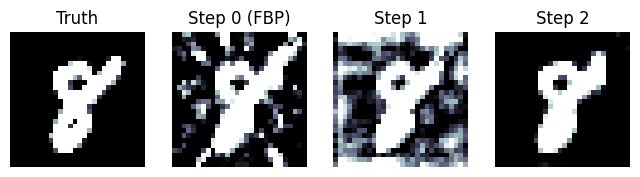

In [15]:
if use_cuda:
    pd_iter_net = pd_iter_net.cpu()
    test_data = test_data.cpu()
    test_images = test_images.cpu()

test_res_pd_iter = pd_iter_net(test_data)

results = [test_images]+test_res_pd_iter

titles = ['Truth', 'Step 0 (FBP)', 'Step 1', 'Step 2']
show_image_matrix(results, titles, indices=0, clim=[0, 1], cmap='bone')

Let's plot all networks and compare them.

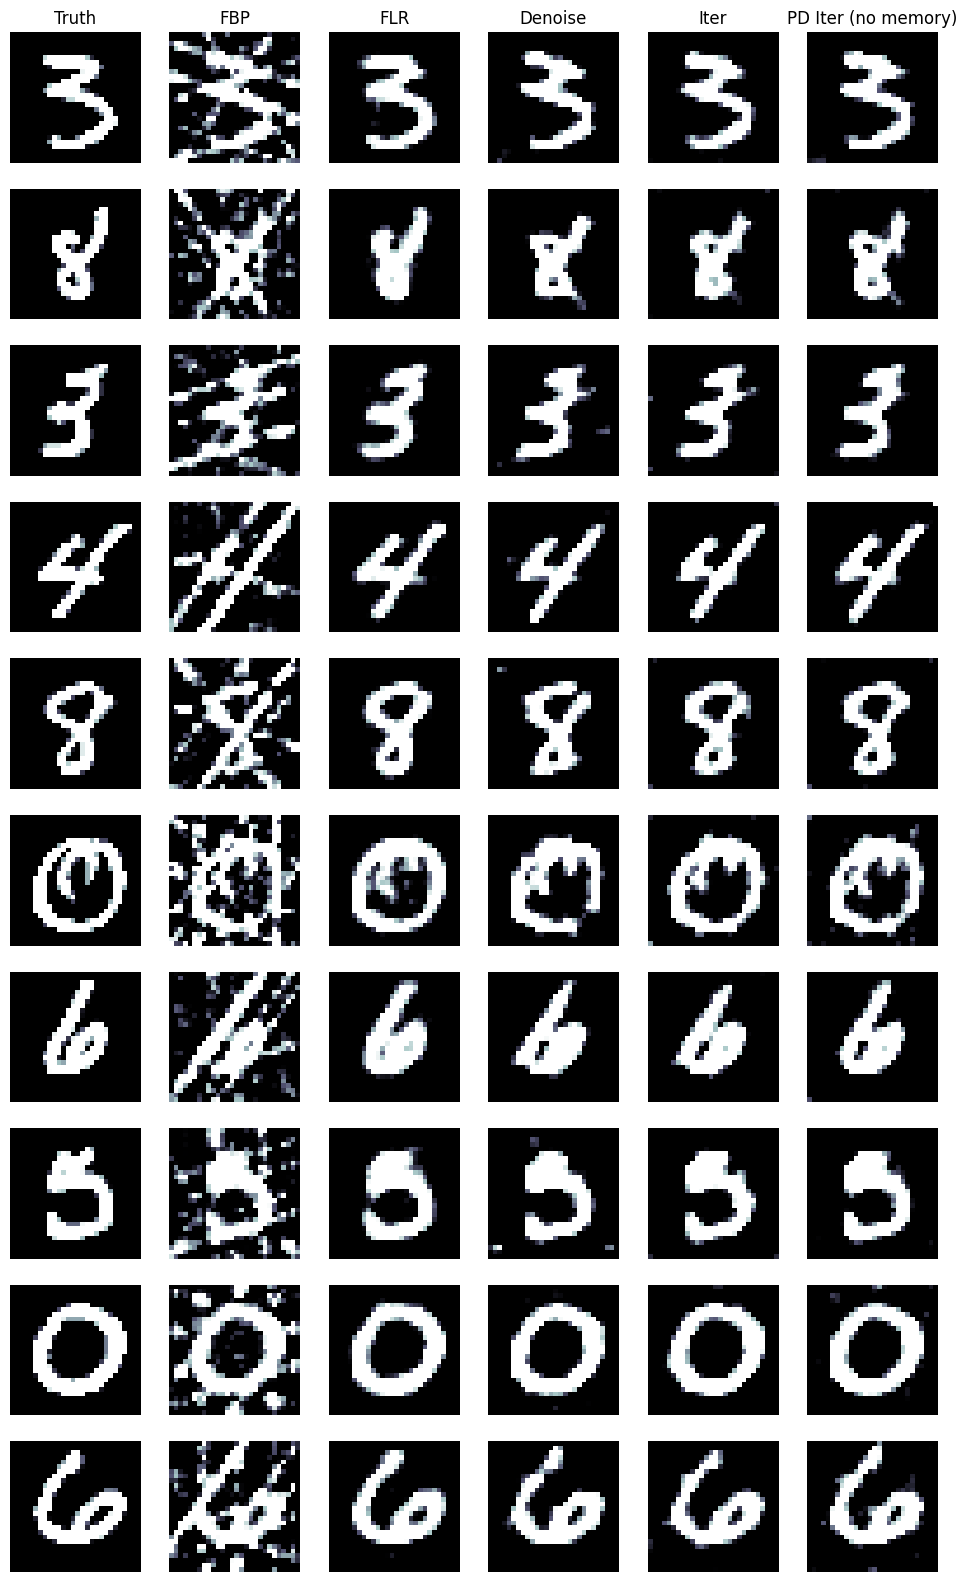

In [16]:
if use_cuda:
    full_net = full_net.cpu()
    denoise_net = denoise_net.cpu()
    iter_net = iter_net.cpu()
    pd_iter_net = pd_iter_net.cpu()
    test_data = test_data.cpu()
    test_images = test_images.cpu()
    
fbp_recos = fbp_op_mod(test_data)
test_res_full = full_net(test_data)
test_res_denoise = denoise_net(fbp_op_mod(test_data))
test_res_iter = iter_net(test_data)
test_res_pd_iter = pd_iter_net(test_data)[-1]
results = [test_images, fbp_recos, test_res_full, test_res_denoise, test_res_iter, test_res_pd_iter]
titles = ['Truth', 'FBP', 'FLR', 'Denoise', 'Iter', 'PD Iter (no memory)']
show_image_matrix(results, titles, indices=slice(10, 20), clim=[0, 1], cmap='bone')

In [17]:
#Trained with use_memory=False 
#Set True and see if cur_y and cur_x will be adversial against the network (yes)
pd_iter_net.usememory(True)
test()


Test set: Average loss: 0.00656985


Also I proposed a version of learned PDHG with memory: this version shows less error than the proposed without memory.

- Let's train the network with option ```use_memory=True``` and see some results.
  - ```pd_iter_net(...)[-1]``` means that we drop intermediate results.

In [18]:
use_cuda = True
learning_rate = 1e-3
log_interval = 20
epochs = 1
pd_iter_net = PDIterativeNet(niter=2, op=fwd_op_mod, op_adj=fwd_op_adj_mod,
                        init_op=fbp_op_mod, use_memory=True)
loss_train = nn.MSELoss()
loss_test = nn.MSELoss()

if use_cuda:
    pd_iter_net = pd_iter_net.cuda()
    test_data = test_data.cuda()
    test_images = test_images.cuda()

optimizer = optim.Adam(pd_iter_net.parameters(), lr=learning_rate)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.1)


def train(epoch):
    pd_iter_net.train()
    for batch_idx, (images, _) in enumerate(train_loader):
        if use_cuda:
            images = images.cuda()
        images = Variable(images)
        projs = generate_data(images)

        optimizer.zero_grad()
        output = pd_iter_net(projs)[-1]
        loss = loss_train(output, images)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBatch Loss: {:.6f}'
                  ''.format(epoch, batch_idx * len(images),
                            len(train_loader.dataset),
                            100. * batch_idx / len(train_loader),
                            loss.item()))


def test():
    pd_iter_net.eval()
    loss = loss_test(pd_iter_net(test_data)[-1], test_images) / len(test_images)
    print('\nTest set: Average loss: {:.8f}'.format(loss.item()))


for epoch in range(1, epochs + 1):
    train(epoch)
    clear_output()
    test()

torch.save(pd_iter_net.state_dict(), "weights/pd_iter_net.tar")

print('Total number of parameters:',
      sum(p.numel() for p in pd_iter_net.parameters()))


Test set: Average loss: 0.00158547
Total number of parameters: 41156


It's better than the version without memory: the number of parameters is the same but there is less error on test set.

Let's see intermediate states.

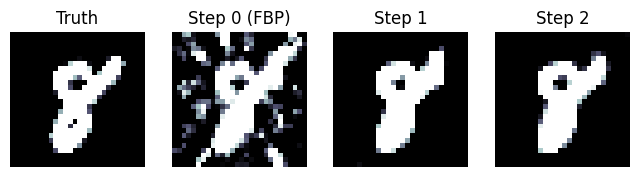

In [19]:
if use_cuda:
    pd_iter_net = pd_iter_net.cpu()
    test_data = test_data.cpu()
    test_images = test_images.cpu()

test_res_pd_iter = pd_iter_net(test_data)

results = [test_images]+test_res_pd_iter

titles = ['Truth', 'Step 0 (FBP)', 'Step 1', 'Step 2']
show_image_matrix(results, titles, indices=0, clim=[0, 1], cmap='bone')

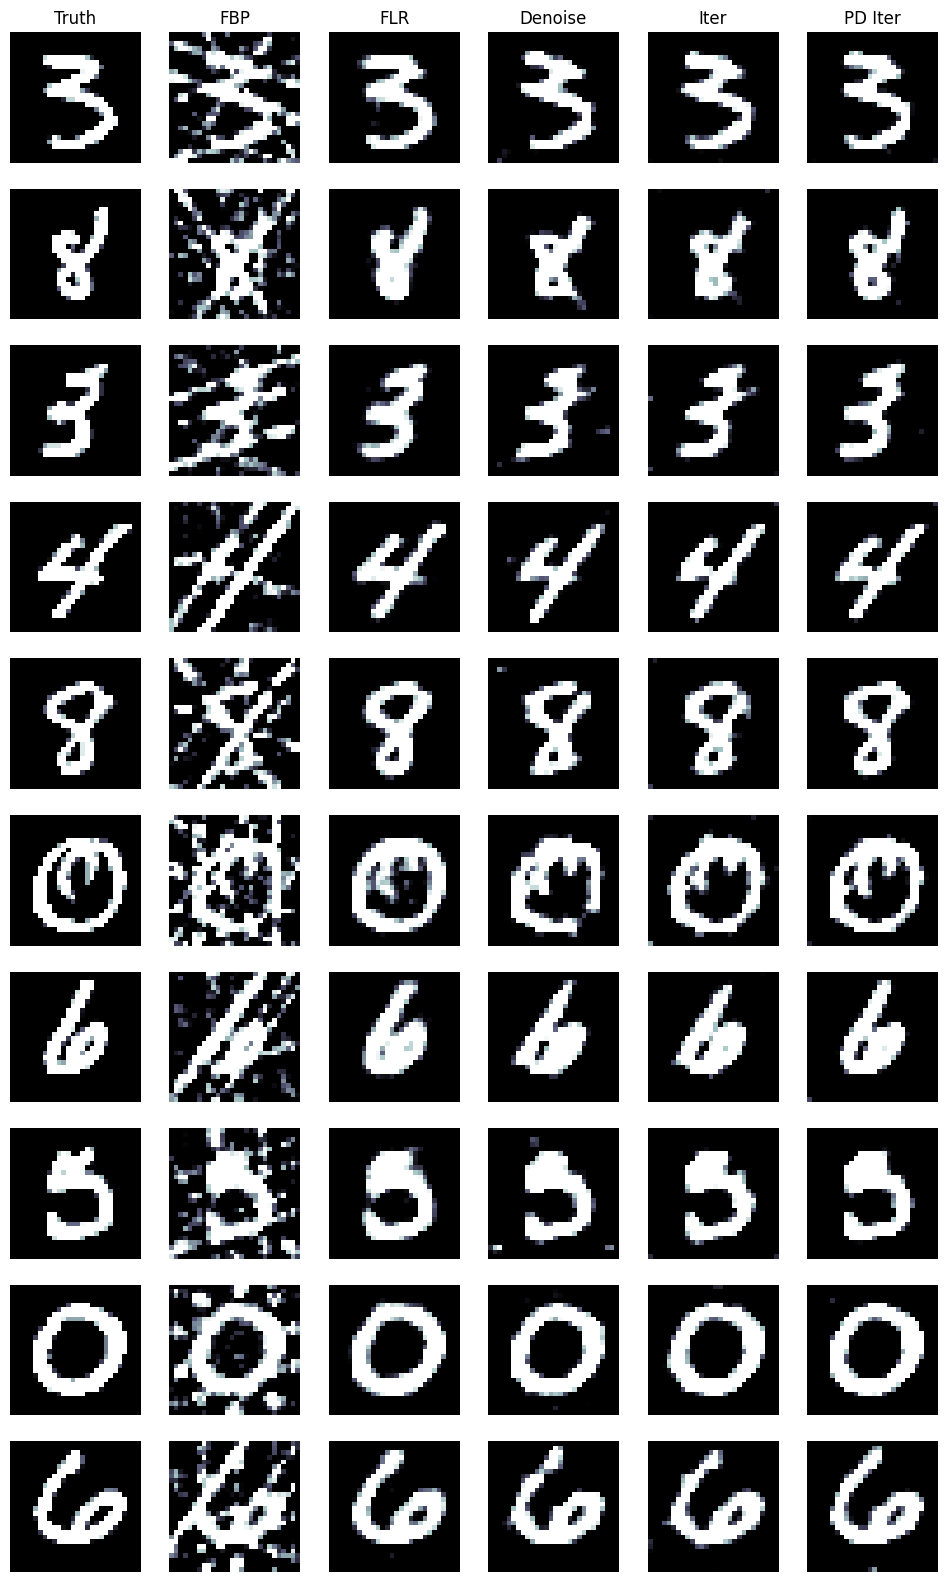

In [20]:
if use_cuda:
    full_net = full_net.cpu()
    denoise_net = denoise_net.cpu()
    iter_net = iter_net.cpu()
    pd_iter_net = pd_iter_net.cpu()
    test_data = test_data.cpu()
    test_images = test_images.cpu()
    
fbp_recos = fbp_op_mod(test_data)
test_res_full = full_net(test_data)
test_res_denoise = denoise_net(fbp_op_mod(test_data))
test_res_iter = iter_net(test_data)
test_res_pd_iter = pd_iter_net(test_data)[-1]
results = [test_images, fbp_recos, test_res_full, test_res_denoise, test_res_iter, test_res_pd_iter]
titles = ['Truth', 'FBP', 'FLR', 'Denoise', 'Iter', 'PD Iter']
show_image_matrix(results, titles, indices=slice(10, 20), clim=[0, 1], cmap='bone')

In [21]:
#Trained with use_memory=True 
#Set False and see if cur_y and cur_x will be adversial against the network (yes, a lot more than last adversial test (as expected))
pd_iter_net.usememory(False)
test()


Test set: Average loss: 0.04607005


Now I compressed all results in the table below. As you can see PDHG performs better than other methods, also with a small number of parameters.

| Method                            | Mean Error (1)  | Mean Error (2)|
|------------------------           |-----------------|---------------|
| FBP                               | 0.01927         | 0.017932
| Fully learned                     | 0.00233         | 0.002374
| FBP + learned denoiser            | 0.00281         | 0.002758
| Learned Iterative                 | 0.005150        | 0.002799
| Learned Iterative (No memory)     | -               | 0.002533
| Learned Iterative (Memory)        | -               | 0.001586

Where (1) are original errors in example notebook and (2) are error obtained by my notebook solution.

Also I checked the adaptation of the network with two test:

1. Learn no memory PDHG and use it in a memory runtime.
2. Learn memory PDHG and use it in a no memory runtime.

| Method                 |  Mean Error  |
|------------------------|--------------|
| (1) Learned PDHG No Memory | 0.00657  |
| (2) Learned PDHG           | 0.04607  |

The results shows that first case is more rubust to this kind of adaptation: it's an expected result because the latter one extract information from the intermediate state.